In [1]:
import pathlib
from typing import Dict, List

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuration
DATA_DIR = pathlib.Path("../../data/annotation/sharing")
OUTPUT_DIR = pathlib.Path("../figures/ED/MB_shared_GEX")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

H5AD_FILE = DATA_DIR / "all_sharing.h5ad.gz"
CLF_DATA = DATA_DIR / "classifier_data.tsv"

TISSUE_RELATIONSHIP = "LN_SP"
MB_IDS = "Memory B|Age-|Prolif"
AS_IDS = "Plasma"
MB_ONLY = True
AS_ONLY = not MB_ONLY
INCLUDE_NON_SHARED = False
USE_META = False
USE_FILTERED = True

TISSUE_COMBO_TO_COLUMN: Dict[str, str] = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

# Figure settings
SAVEFIG_ARGS = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}
OUTPUT_FORMATS = [".png", ".pdf"]

def setup_plotting():
    mpl.rc("savefig", dpi=300)
    sc.set_figure_params(
        dpi_save=150,
        frameon=False,
        vector_friendly=True,
        fontsize=6,
        figsize=(3,3),
        format='pdf',
        transparent=True
    )
    sns.set_style("ticks")
    plt.style.use('../scripts/bursa.mplstyle')

def setup_pandas_display():
    pd.set_option("display.max_rows", 50)
    pd.set_option("display.max_columns", 20)
    pd.set_option("display.width", 100)

def get_gene_feature_sets() -> List[pathlib.Path]:
    return [
        DATA_DIR / TISSUE_RELATIONSHIP / "mb_cells/de_genes_true.tab",
        DATA_DIR / TISSUE_RELATIONSHIP / "mb_cells/filtered_de_genes_false.tab",
        DATA_DIR / TISSUE_RELATIONSHIP / "mb_cells/de_genes.tab"
    ]

def save_figure(fig, name: str, output_suffix: str = ""):
    for output_format in OUTPUT_FORMATS:
        fig.savefig(OUTPUT_DIR / f"{name}{output_suffix}{output_format}", **SAVEFIG_ARGS)


In [2]:
def convert_boolean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns containing 'True' or 'False' strings to boolean type.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].dropna().isin(['True', 'False']).all():
                df[column] = df[column].map({'True': True, 'False': False})
    return df

def plot_feature_importances(importances: np.ndarray, feature_names: List[str], title: str):
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_importances = importances[sorted_indices]
    
    data = pd.DataFrame({'Feature': sorted_features, 'Importance': sorted_importances})
    
    fig, ax = plt.subplots(figsize=(1.25, 4))
    sns.barplot(x='Importance', y='Feature', data=data, ax=ax, orient='h', color='k')
    ax.tick_params(axis='both', which='minor', size=0)
    plt.xlabel('Importance\n(Regression Coefficient)')
    plt.ylabel('Feature')
    plt.title(title)
    return fig

def create_ecdf_plot(df: pd.DataFrame, tissue_combo_to_column: Dict[str, str]):
    fig = plt.figure(figsize=(3, 1.5))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])

    df = df.fillna({col: False for col in df.filter(like='shared_').columns})

    n_colors = len(df.filter(like='shared_').columns)
    shades_of_red = sns.color_palette("Reds", n_colors=n_colors)
    shades_of_blue = sns.color_palette("Blues", n_colors=n_colors)

    for idx, tissue_combo in enumerate(df.filter(like='shared_').columns):
        human_readable_label = next((k for k, v in tissue_combo_to_column.items() if v == tissue_combo), tissue_combo)
        
        for is_shared, color in [(True, shades_of_red[idx]), (False, shades_of_blue[idx])]:
            tissue_df = df[df[tissue_combo] == is_shared]
            sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                         color=color, label=f"{human_readable_label} {'True' if is_shared else 'False'}")

    ax.set_xlabel("Decision Score")
    ax.set_ylabel("Fraction of Memory B Cells\nwith higher score")
    ax.set_xlim(0, 3)
    sns.despine()

    return fig, gs

def create_color_table(fig: plt.Figure, gs: gridspec.GridSpec, tissue_combo_to_column: Dict[str, str], shades_of_red: List, shades_of_blue: List):
    ax_table = plt.subplot(gs[1])
    ax_table.axis('off')

    table_colors = list(zip(shades_of_red, shades_of_blue))
    cell_text = [[key.replace('_', ' '), '', ''] for key in tissue_combo_to_column]
    col_labels = ["Shared\nBetween", "True", "False"]
    col_widths = [0.6, 0.3, 0.3]

    table = ax_table.table(cellText=cell_text, colLabels=col_labels, loc='center', 
                           cellLoc='center', colWidths=col_widths)

    for (row, _), colors in zip(enumerate(tissue_combo_to_column, start=1), table_colors):
        table[row, 0].set_facecolor('none')
        for col, color in enumerate(colors, start=1):
            cell = table[row, col]
            cell.set_facecolor(color)
            cell.set_text_props(color='w')

    for cell in table.get_celld().values():
        cell.set_edgecolor('none')

    table.auto_set_font_size(False)
    table.set_fontsize(6)
    table.scale(0.6, 0.7)

    plt.subplots_adjust(wspace=0)


In [3]:
setup_plotting()
setup_pandas_display()    
gene_feature_sets = get_gene_feature_sets()

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


2119 shared B cells
73499 not shared B cells


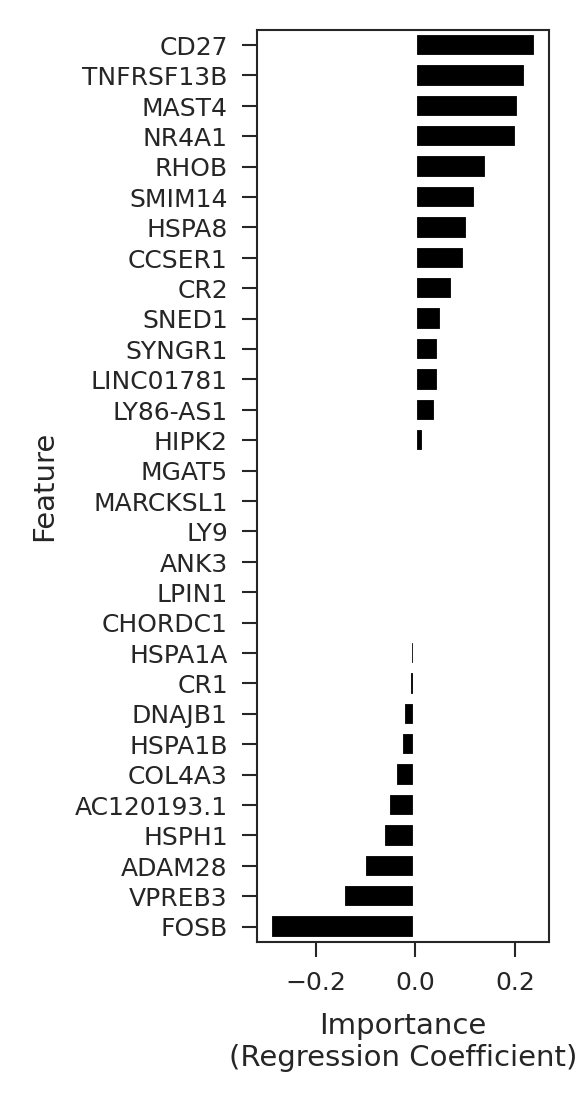

In [5]:
# Load the data
ad = sc.read_h5ad(H5AD_FILE)

if MB_ONLY:
    ad = ad[ad.obs.celltypist.str.contains(MB_IDS, regex=True)]
if AS_ONLY:
    ad = ad[ad.obs.celltypist.str.contains(AS_IDS, regex=True)]

ad.obs = convert_boolean_columns(ad.obs)
ad.obs.loc[:,'shared'] = ad.obs[f"shared_{TISSUE_RELATIONSHIP}"]
print(ad.obs.shared.value_counts().xs(True), "shared B cells")
print(ad.obs.shared.value_counts().xs(False), "not shared B cells")

# Extract feature set from DEG analysis
gene_feature_sets = get_gene_feature_sets()

if USE_FILTERED:
    shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset='names').names[:30]
else:
    shared_genes = pd.read_table(gene_feature_sets[2], index_col=0).dropna(subset='names').names[:30]
    
# i.e. genes which predict membership in the non-shared class
non_shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset='names')['names'].iloc[:15]

if INCLUDE_NON_SHARED:
    feature_genes = list(shared_genes) + list(non_shared_genes)
else:
    feature_genes = list(shared_genes)
response_vars = list(TISSUE_COMBO_TO_COLUMN.values())

if USE_META:
    meta_vars = ['switched', 'v_mismatch', 'celltypist']
else:
    meta_vars = []

features = feature_genes + meta_vars + response_vars
df = sc.get.obs_df(ad, keys=features)

df.to_csv(CLF_DATA, sep='\t')
df = pd.read_table(CLF_DATA)

shared_column = f"shared_{TISSUE_RELATIONSHIP}"
df['shared'] = df[shared_column]
for val in TISSUE_COMBO_TO_COLUMN.values():
    df.pop(val)

df.dropna(subset=['shared'], inplace=True)
df['shared'] = df['shared'].astype(bool)

if 'cb_suid' in df.columns:
    df = df.drop(columns=['cb_suid'])

class_counts = df['shared'].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

df_majority = df[df['shared'] == majority_class]
df_minority = df[df['shared'] == minority_class]
df_majority_undersampled = df_majority.sample(len(df_minority))
df_undersampled = pd.concat([df_majority_undersampled, df_minority])
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

X = df_undersampled.drop('shared', axis=1)
y = df_undersampled['shared']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

log_y_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
log_classification_rep = classification_report(y_test, log_y_pred)

log_feature_importances = log_reg.coef_[0]

fig = plot_feature_importances(log_feature_importances, X.columns, '')
save_figure(fig, "LogisticRegression_Feature_Importance")

## Plotting Decision Scores

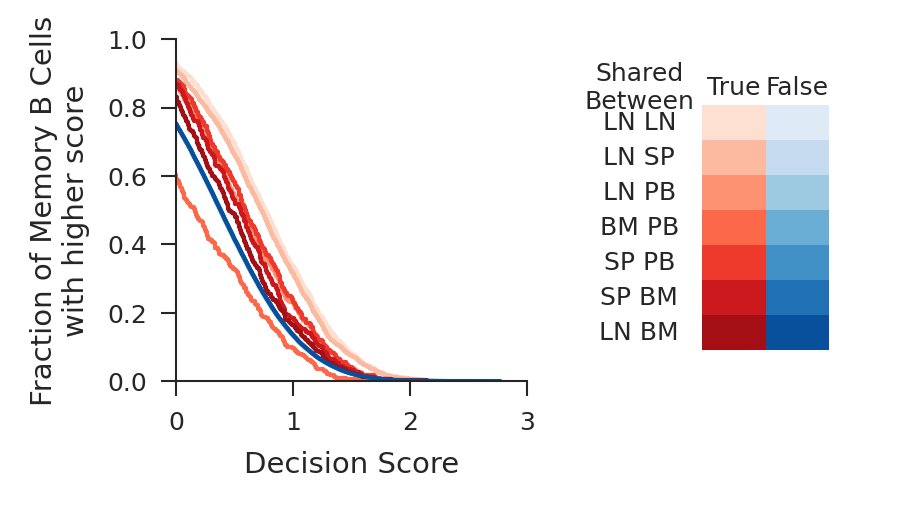

In [6]:
# Read CLF_DATA and calculate decision scores for plotting
df = pd.read_table(CLF_DATA)
if 'cb_suid' in df.columns:
    df = df.set_index('cb_suid')

X_index = len(TISSUE_COMBO_TO_COLUMN)
X = df.iloc[:, :-X_index].values
decision_scores = log_reg.decision_function(X)
df['decision_scores'] = decision_scores

# Create ECDF plot
fig, gs = create_ecdf_plot(df, TISSUE_COMBO_TO_COLUMN)

# Define color palettes
n_colors = len(df.filter(like='shared_').columns)
shades_of_red = sns.color_palette("Reds", n_colors=n_colors)
shades_of_blue = sns.color_palette("Blues", n_colors=n_colors)

# Create color table
create_color_table(fig, gs, TISSUE_COMBO_TO_COLUMN, shades_of_red, shades_of_blue)

# Save the figure
save_figure(fig, "ecdf_logreg_scores")